In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astromodal.config import load_config
from tqdm import tqdm
import polars as pl
import random
from pathlib import Path
from astromodal.datasets.datacubes import load_datacube_files

In [3]:
config = load_config("/home/schwarz/projetoFM/config.yaml")

hdd_folder = config['hdd_folder']

hddfolder = Path(config["hdd_folder"]) / "image_latents" 

In [4]:
file = config['datacubes_paths'].replace('*', 'STRIPE82-0002')

import polars as pl

header = pl.read_parquet(file, n_rows=0)
columns = [col for col in header.columns if 'desi' in col] + ["id", "mag_psf_r"]

In [5]:
train_files, val_files = load_datacube_files(config['datacubes_paths'], train_val_split=0.9, nfiles_subsample=10)

[info] - Found 2444 datacube files
[info] - Subsampled to 10 files
[info] - Training files: 9
[info] - Validation files: 1


In [6]:
train_df = None

for f in tqdm(train_files, desc="Loading train files"):
    try:
        df = pl.read_parquet(f, columns=columns, use_pyarrow=True)
        df = df.filter(pl.col(columns[0]).is_not_null())
        
        df = df.filter(pl.col("mag_psf_r") < 21)
        
        
        if df.height == 0:
            continue

        train_df = df if train_df is None else pl.concat([train_df, df], how="vertical", rechunk=False)
    except Exception as e:
        pass


Loading train files:   0%|          | 0/9 [00:00<?, ?it/s]

Loading train files: 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]


In [7]:
train_df = train_df.filter(pl.col("desi_TARGET_RA").is_not_null())

In [111]:
from pathlib import Path
model.save(Path(config['models_folder']) / "spectra_autoencoder_desi.pth")

In [19]:
from astromodal.models.spectral_autoencoder import SpectraAutoEncoder
from astromodal.models.scaler1d import StandardScaler1D
from astromodal.tokenizers.spectralrvq import SpectralPatchRVQ

model = SpectraAutoEncoder.load_from_file(Path(config['models_folder']) / "spectra_autoencoder_desi.pth")
model.eval()

scaler = StandardScaler1D.load(Path(config['models_folder']) / "scalers" / "desi_flux_standard_scaler.npz")

tok = SpectralPatchRVQ.load_from_file(Path(config['models_folder']) / "spectral_patch_rvq_desi.pth")

[info] - Loaded spectra AE (flux-only) from /home/schwarz/projetoFM/outputs/spectra_autoencoder_desi.pth
[info] - Loaded SpectralPatchRVQ from /home/schwarz/projetoFM/outputs/spectral_patch_rvq_desi.pth


In [29]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from astromodal.datasets.desi_spectra import stitch_desi_arms

@torch.no_grad()
def run_full_chain_and_plot_with_scaler(
    row,
    ae_model,
    tok_model,
    scaler,                 # <-- NEW
    device="cuda",
    *,
    plot=True,
    max_points=None,
):
    ae_model.eval().to(device)
    tok_model.eval().to(device)

    # -------------------------
    # 1) stitch
    # -------------------------
    w, f, iv, mask = stitch_desi_arms(
        row.get("desi_wave_b"), row.get("desi_flux_b"), row.get("desi_ivar_b"),
        row.get("desi_wave_r"), row.get("desi_flux_r"), row.get("desi_ivar_r"),
        row.get("desi_wave_z"), row.get("desi_flux_z"), row.get("desi_ivar_z"),
    )
    if f.size == 0:
        return None

    mask = mask.astype(bool)

    # optional plot downsample (keeps mask alignment)
    if max_points is not None and f.size > max_points:
        idx = np.linspace(0, f.size - 1, max_points).astype(int)
        w = w[idx]
        f = f[idx]
        mask = mask[idx]
        iv = iv[idx]

    # -------------------------
    # 2) normalize using SCALER (survey-level)
    # -------------------------
    # Important: scaler should have been trained on DESI flux values in the SAME units
    f_norm = scaler.transform_x(f).astype(np.float32)   # [L]

    x = torch.from_numpy(f_norm[:, None]).unsqueeze(0).to(device)  # [1,L,1]
    L = x.shape[1]

    # -------------------------
    # 3) AE encode/decode (normalized space)
    # -------------------------
    z_ae = ae_model.encode(x)                                # [1, C_lat, T]
    xhat_ae_norm = ae_model.decode(z_ae, L_out=L)            # [1, L, 1]
    fhat_ae_norm = xhat_ae_norm[0, :, 0].detach().cpu().numpy()

    # inverse scaler back to flux space
    fhat_ae = scaler.inverse_transform_x(fhat_ae_norm)

    # latent sequence for tokenizer: [B, T, C_lat]
    z_seq = z_ae.transpose(1, 2).contiguous()               # [1, T, C_lat]
    T = z_seq.shape[1]
    C_lat = z_seq.shape[2]

    if hasattr(tok_model, "channels") and int(tok_model.channels) != int(C_lat):
        raise ValueError(
            f"Tokenizer channels={tok_model.channels} but AE latent_dim={C_lat}. "
            f"Instantiate tok with channels=latent_dim."
        )

    # -------------------------
    # 4) Tokenizer encode/decode in latent space
    # -------------------------
    enc_tok = tok_model.encode(z_seq, update_ema=False)
    codes = enc_tok["codes"]              # [1, T_tok, R]
    T_tok = int(enc_tok["T"])
    L_lat = int(enc_tok["L"])             # should equal T (latent length)

    zq_seq = tok_model.decode(codes, L=L_lat)     # [1, L_lat, C_lat]
    zq_seq = zq_seq[:, :T, :]                     # [1, T, C_lat] match AE z length

    # -------------------------
    # 5) Decode tokenizer-quantized latents back to flux
    # -------------------------
    zq_ae = zq_seq.transpose(1, 2).contiguous()   # [1, C_lat, T]
    xhat_final_norm = ae_model.decode(zq_ae, L_out=L)  # [1, L, 1]
    fhat_final_norm = xhat_final_norm[0, :, 0].detach().cpu().numpy()

    # inverse scaler back to flux space
    fhat_final = scaler.inverse_transform_x(fhat_final_norm)

    # -------------------------
    # 6) residuals (flux units)
    # -------------------------
    resid_ae = fhat_ae - f
    resid_final = fhat_final - f
    resid_final_vs_ae = fhat_final - fhat_ae

    # -------------------------
    # 6b) residuals in sigma units (chi), using DESI ivar
    # chi = (fhat - f) / sigma_noise = (fhat - f) * sqrt(ivar)
    # -------------------------
    chi_ae = np.full_like(f, np.nan, dtype=np.float64)
    chi_final = np.full_like(f, np.nan, dtype=np.float64)
    chi_final_vs_ae = np.full_like(f, np.nan, dtype=np.float64)

    good = mask & np.isfinite(iv) & (iv > 0)
    if np.any(good):
        s = np.sqrt(iv[good])
        chi_ae[good] = resid_ae[good] * s
        chi_final[good] = resid_final[good] * s
        chi_final_vs_ae[good] = resid_final_vs_ae[good] * s

    out = {
        "wave": w,
        "mask": mask,
        "ivar": iv,
        "flux": f,
        "flux_hat_ae": fhat_ae,
        "flux_hat_final": fhat_final,
        "resid_ae_minus_orig": resid_ae,
        "resid_final_minus_orig": resid_final,
        "resid_final_minus_ae": resid_final_vs_ae,
        "chi_ae_minus_orig": chi_ae,
        "chi_final_minus_orig": chi_final,
        "chi_final_minus_ae": chi_final_vs_ae,
        "latent_ae_ct": z_ae[0].detach().cpu().numpy(),      # [C_lat, T]
        "latent_tok_tc": zq_seq[0].detach().cpu().numpy(),   # [T, C_lat]
        "codes": codes.detach().cpu(),                       # [1, T_tok, R]
    }

    # -------------------------
    # 7) plotting
    # -------------------------
    if plot:
        m = mask

        fig, axes = plt.subplots(
            5, 1, figsize=(12, 12), sharex=True,
            gridspec_kw={"hspace": 0.50}
        )

        axes[0].plot(w[m], f[m], lw=1)
        axes[0].set_ylabel("Flux")
        axes[0].set_title("Original (stitched)")

        axes[1].plot(w[m], fhat_ae[m], lw=1)
        axes[1].set_ylabel("Flux")
        axes[1].set_title("AE reconstruction (scaler inverse)")

        axes[2].plot(w[m], fhat_final[m], lw=1)
        axes[2].set_ylabel("Flux")
        axes[2].set_title("Final reconstruction (AE ∘ Tok ∘ AE) (scaler inverse)")

        axes[3].plot(w[m], resid_ae[m], lw=1, label="AE − Orig", alpha=0.5)
        axes[3].plot(w[m], resid_final_vs_ae[m], lw=1, label="Final − AE", alpha=0.5)
        axes[3].plot(w[m], resid_final[m], lw=1, label="Final − Orig", alpha=0.5)
        axes[3].axhline(0.0, ls="--", lw=0.8, alpha=0.7)
        
        # set y-axis limits to between -5 and +5 flux units
        ymin, ymax = axes[3].get_ylim()
        axes[3].set_ylim(max(ymin, -5), min(ymax, 5))
        
        axes[3].set_ylabel("Δ Flux")
        axes[3].set_title("Residuals (flux units)")
        axes[3].legend()

        axes[4].plot(w[good], chi_ae[good], lw=1, label="(AE − Orig) / σ", alpha=0.6)
        axes[4].plot(w[good], chi_final_vs_ae[good], lw=1, label="(Final − AE) / σ", alpha=0.6)
        axes[4].plot(w[good], chi_final[good], lw=1, label="(Final − Orig) / σ", alpha=0.6)
        axes[4].axhline(0.0, ls="--", lw=0.8, alpha=0.7)
        axes[4].axhline(+1.0, ls=":", lw=0.8, alpha=0.5)
        axes[4].axhline(-1.0, ls=":", lw=0.8, alpha=0.5)
        axes[4].axhline(+3.0, ls=":", lw=0.8, alpha=0.5)
        axes[4].axhline(-3.0, ls=":", lw=0.8, alpha=0.5)
        
        # limit y-axis to between -5 and +5
        ymin, ymax = axes[4].get_ylim()
        axes[4].set_ylim(max(ymin, -5), min(ymax, 5))
        
        axes[4].set_ylabel("Residual (σ units)")
        axes[4].set_xlabel("Wavelength")
        axes[4].set_title("Residuals in sigma units (χ), using DESI ivar")
        axes[4].legend()

        plt.tight_layout()
        plt.show()

    return out

/tmp/ipykernel_2587927/3341244098.py:187: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


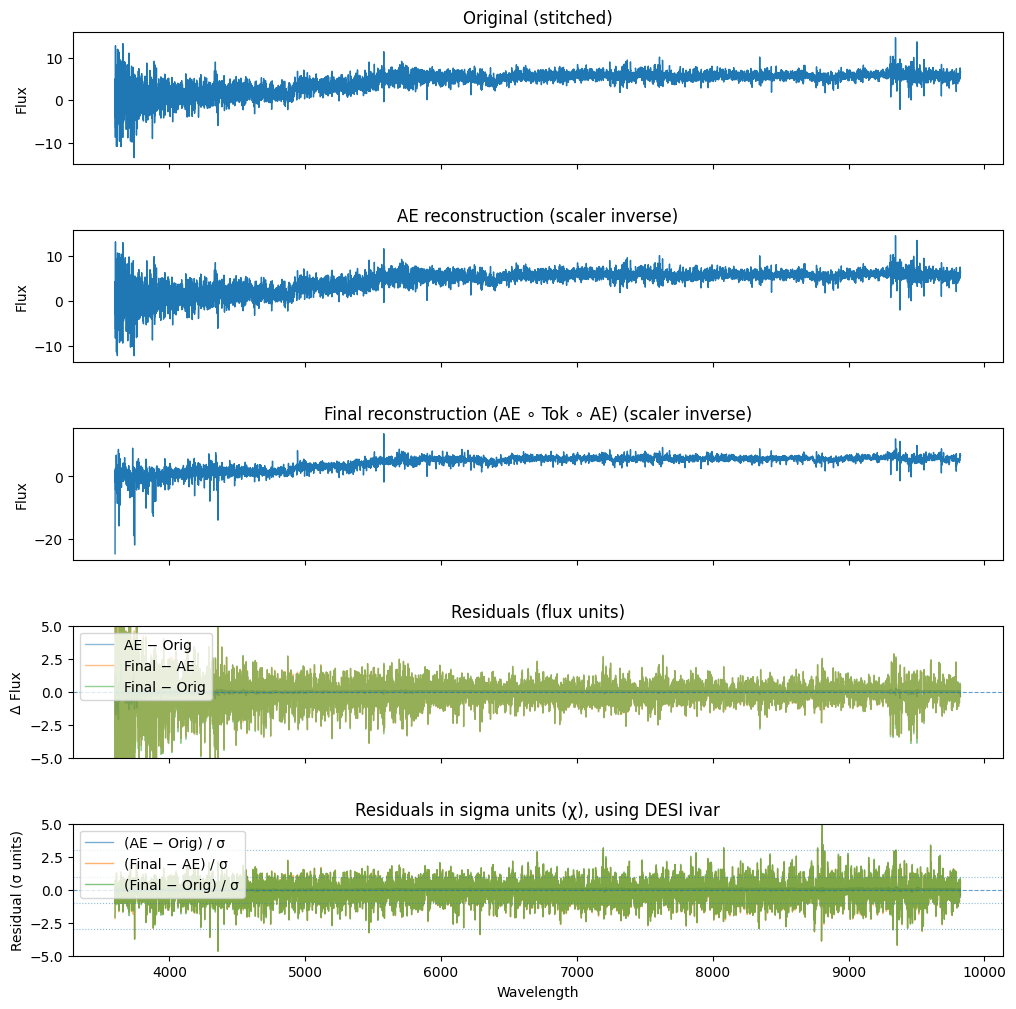

In [32]:
row = train_df.row(random.randint(0, train_df.height - 1), named=True)

out = run_full_chain_and_plot_with_scaler(
    row=row,
    ae_model=model,
    tok_model=tok,     # trained RVQ tokenizer over AE latents
    scaler=scaler,     # added scaler
    device="cuda",
    plot=True,
)

In [28]:
tok.save(Path(config['models_folder']) / "spectral_patch_rvq_desi.pth")

[info] - Saved SpectralPatchRVQ to /home/schwarz/projetoFM/outputs/spectral_patch_rvq_desi.pth
